# Evolution velocity analysis

This notebook shows the evolution velocity analysis based on python package Evolocity developed by Hie at el. 

## Set up the analysis

### Import the python modules

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import scipy.stats as ss
import time
from dateutil.parser import parse as dparse
from Bio.Seq import Seq
import pickle
import evolocity as evo
from utils.evo_velocity_utils import velocity_graph
from evolocity.pl import scatter
from evolocity.pl import utils
from anndata import AnnData
from cov import seqs_to_anndata
from cmcrameri import cm

### Read in data

First run run_evo.sh using gpu to prepare the data used for plot. 

In [2]:
with open('../result/target/ev_cache/cov_seqs.pkl', 'rb') as f:
    seqs = pickle.load(f)

In [3]:
gisaid_seq=pd.read_csv('../data/unique_GISAID.csv',index_col=0)

In [4]:
seqs = dict((key,value) for key,value in seqs.items() if str(key) in gisaid_seq["seq"].to_list())

In [5]:
gisaid_seq.head()

n_seq                                                seq  seqlen  \
0  602966  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...     201   
1   45917  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...     201   
2   55547  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...     201   
3   26230  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...     201   
4  895810  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...     201   

                                    gene_id        date     timestamp   host  \
0          hCoV-19/Wuhan/IPBCAMS-WH-01/2019  2019-12-24  1.577135e+09  human   
1                hCoV-19/Nigeria/CV714/2020  2020-01-01  1.577826e+09  human   
2  hCoV-19/France/PAC-IHU-37302-Nova1M/2020  2020-01-01  1.577826e+09  human   
3         hCoV-19/England/NORT-1B7E6B2/2020  2020-01-01  1.577826e+09  human   
4          hCoV-19/England/PORT-2E44AA/2020  2020-01-01  1.577826e+09  human   

   group  country         continent dataset  \
0  human    Wuhan    Asia (Eastern)  gisaid   
1  human  Nigeria  Africa (Western)  gisaid   
2  human   France            Europe  gisaid   
3  human  England            Europe  gisaid   
4  human  England            Europe  gisaid   

                                           accession  
0  Spike|hCoV-19/Wuhan/IPBCAMS-WH-01/2019|2019-12...  
1  Spike|hCoV-19/Nigeria/CV714/2020|2020-00-00|EP...  
2  Spike|hCoV-19/France/PAC-IHU-37302-Nova1M/2020...  
3  Spike|hCoV-19/England/NORT-1B7E6B2/2020|2020-0...  
4  Spike|hCoV-19/England/PORT-2E44AA/2020|2020-00...

In [6]:
VOC=pd.read_csv('../data/sars-cov-2_variants_update.csv',index_col=0)

In [7]:
VOC

name   Lineages                                          Mutations  \
0    Alpha    B.1.1.7                                              N501Y   
1     Beta    B.1.351                                  K417N;E484K;N501Y   
2    Gamma        P.1                                  K417T;E484K;N501Y   
3    Delta  B.1.617.2                                        L452R;T478K   
4  Omicron  B.1.1.529  G339D;S371L;S373P;S375F;K417N;N440K;G446S;S477...   
5  Omicron       BA.2  G339D;S371F;S373P;S375F;T376A;D405N;R408S;K417...   
6       wt         wt                                                NaN   

                                                 seq  
0  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...  
1  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...  
2  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...  
3  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...  
4  NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFT...  
5  NITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNFAPFFA...  
6  NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...

## Evolution velocity plot for our model

In [87]:
## Load the embeddings of the seqs
gisaid_embedding=np.load('/home/chenn0a/chenn0a/covid_esm1b/AttackProtein2/analysis/data/gisaid_embedding.npy')
gisaid_embedding=gisaid_embedding.reshape(gisaid_embedding.shape[0],-1)

In [9]:
gisaid_score=pd.read_csv('/home/chenn0a/chenn0a/covid_esm1b/AttackProtein2/analysis/data/gisaid_score.csv',index_col=0)
score_dict=gisaid_score.set_index('seq')["mean_score"].to_dict()

In [88]:
for i,seq in enumerate(gisaid_seq["seq"]):
    for meta in seqs[Seq(seq)]:
        meta['embedding'] = gisaid_embedding[i]
        meta['score'] = score_dict[seq]

In [11]:
adata = seqs_to_anndata(seqs)
adata = adata[
            adata.obs['timestamp'] >=
            time.mktime(dparse('2019-12-24').timetuple())
        ]

In [12]:
sc.pp.neighbors(adata,n_neighbors=35,use_rep='X')
sc.tl.louvain(adata, resolution=1.)
sc.tl.umap(adata, min_dist=1.,random_state=3)


Construct the velocity graph based on the prediction of our model

In [13]:
velocity_graph(adata, model_name="esm1b",score="confidence")

100%|██████████| 7594/7594 [00:01<00:00, 5594.73it/s]


Compute the pseudotime

In [14]:
evo.tl.velocity_pseudotime(adata,n_dcs=2,root_key=0)

In [15]:
## The spearman correlation
ss.spearmanr(adata.obs['velocity_pseudotime'],adata.obs['timestamp'],nan_policy='omit')

SpearmanrResult(correlation=0.5455942059684031, pvalue=0.0)

In [16]:
evo.tl.velocity_embedding(adata, basis='umap', scale=1.,
                            self_transitions=True,
                            use_negative_cosines=True,
                            retain_scale=False,
                            autoscale=True,)

computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 500x550 with 0 Axes>

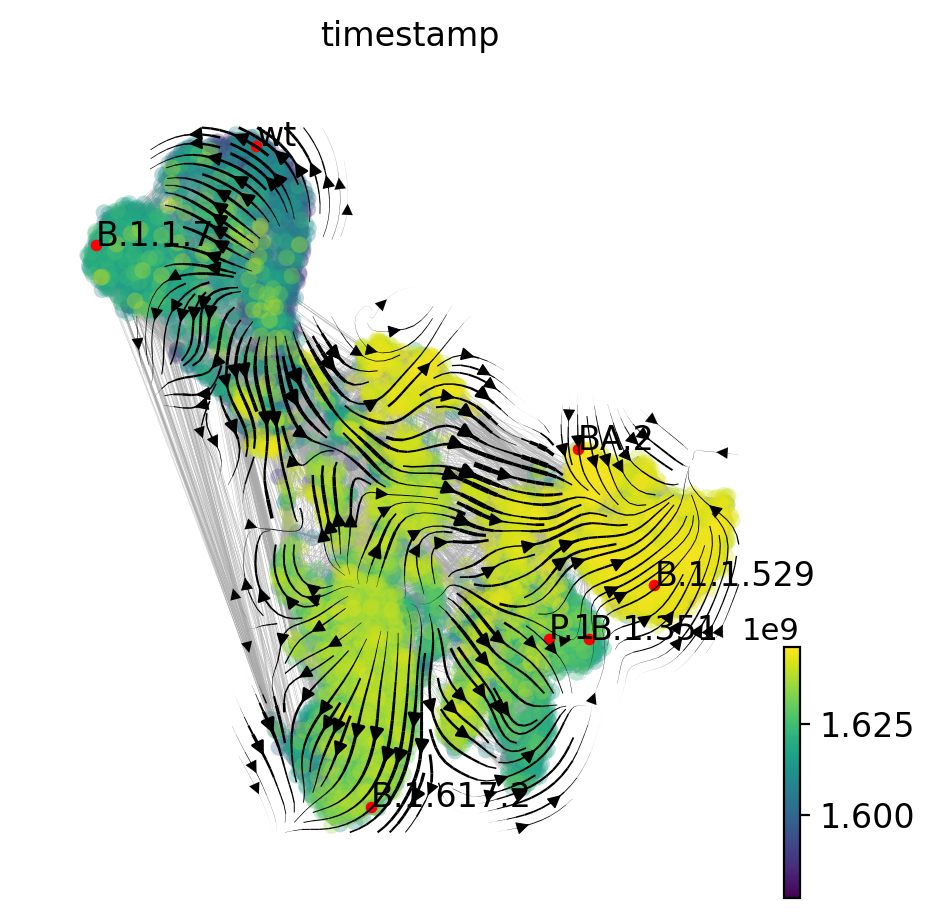

In [19]:
evo.set_figure_params(dpi_save=500, figsize=(5, 5.5))
plt.figure()
ax = evo.pl.velocity_embedding_stream(
    adata, basis='umap', min_mass=1., smooth=1., density=1.2,
    color='timestamp',show=False
    
)

sc.pl._utils.plot_edges(ax, adata, 'umap', 0.1, '#aaaaaa')
voc_name=VOC['Lineages'].values
for variant in voc_name:
    Y=adata[adata.obs["seq"]==VOC[VOC["Lineages"]==variant]["seq"].values[0]].obsm["X_umap"]
    sc.pl._utils.scatter_single(ax,Y,color="red")
    ax.annotate(variant, (Y[:,0], Y[:,1]))
#plt.savefig('figures/gisaid_stream_label.png', dpi=500)


<Figure size 500x550 with 0 Axes>

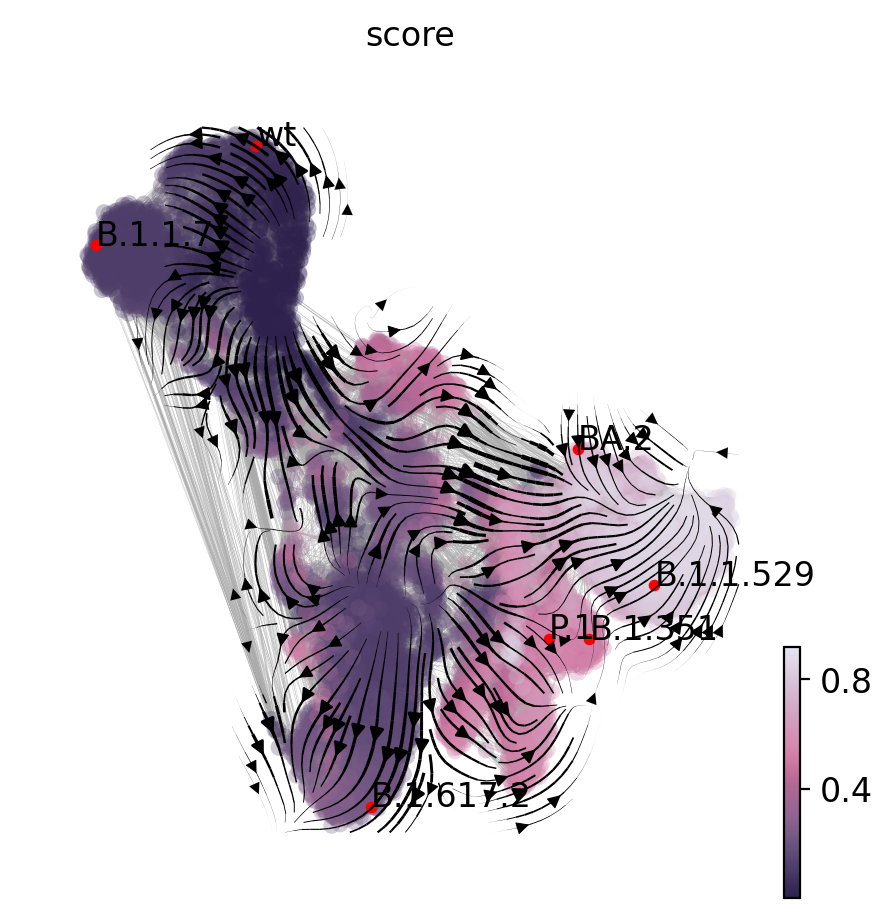

In [20]:
plt.figure()
ax = evo.pl.velocity_embedding_stream(
    adata, basis='umap', min_mass=1., smooth=1., density=1.2,
    color='score',show=False,color_map=cm.acton
    
)

sc.pl._utils.plot_edges(ax, adata, 'umap', 0.1, '#aaaaaa')
voc_name=VOC['Lineages'].values
for variant in voc_name:
    Y=adata[adata.obs["seq"]==VOC[VOC["Lineages"]==variant]["seq"].values[0]].obsm["X_umap"]
    sc.pl._utils.scatter_single(ax,Y,color="red")
    ax.annotate(variant, (Y[:,0], Y[:,1]))
#plt.savefig('figures/gisaid_score_label.png', dpi=500)


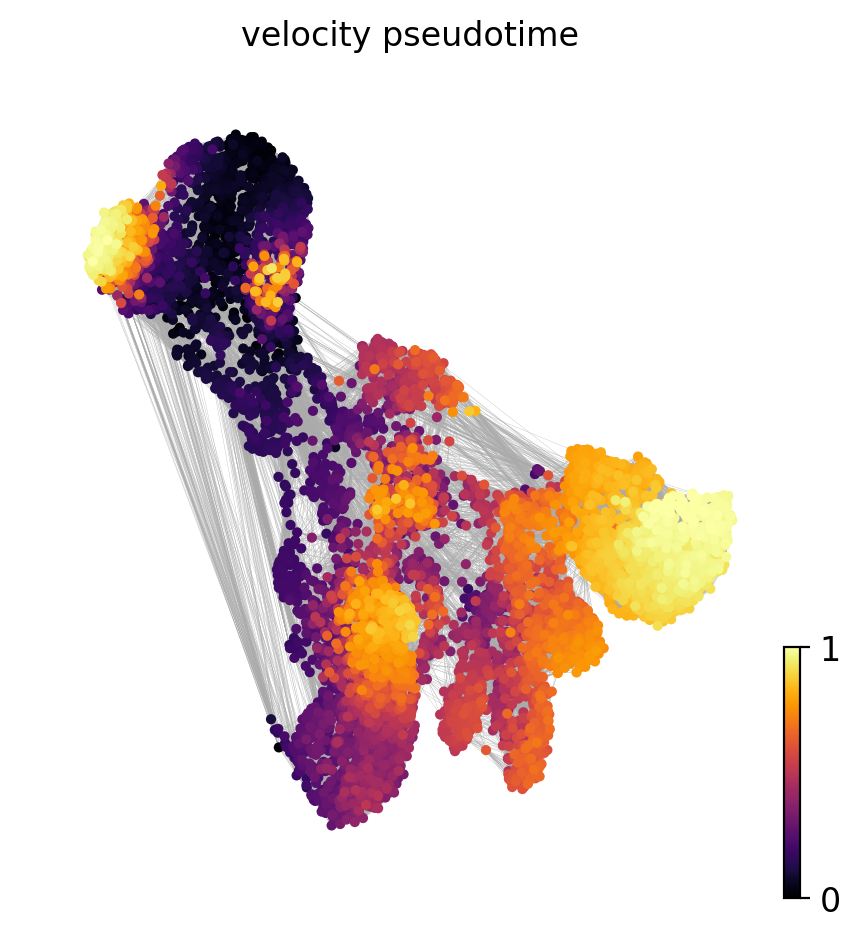

In [21]:
ax=scatter.scatter(adata,basis="umap",color="velocity_pseudotime",cmap='inferno',show=False,size=3*utils.default_size(adata),zorder=0)
sc.pl._utils.plot_edges(ax, adata, 'umap', 0.1, '#aaaaaa')
#plt.savefig('figures/gisaid_pseudotime.png', dpi=500)

computing terminal states
    identified 0 region of root nodes and 6 regions of end points .
    finished (0:00:04) --> added
    'root_nodes', root nodes of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


<Figure size 500x550 with 0 Axes>

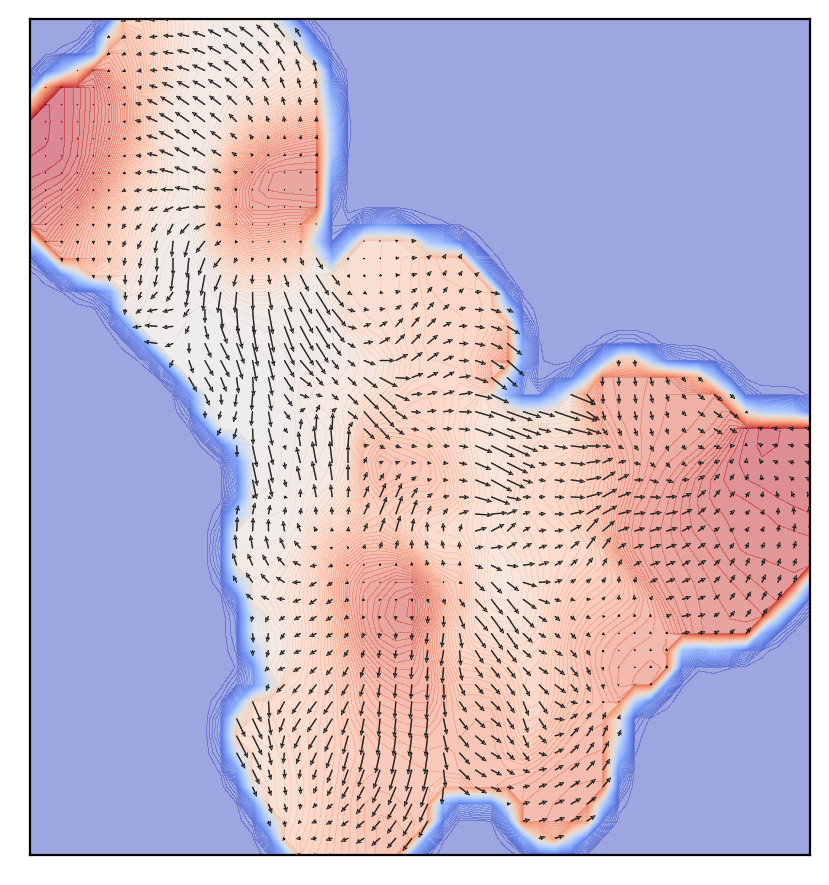

In [22]:
plt.figure()
ax=evo.pl.velocity_contour(
    adata,
    basis='umap', smooth=1., pf_smooth=1.5, levels=100,
    arrow_size=1., arrow_length=3., cmap='coolwarm',
    c='#aaaaaa',show=False
)
#plt.savefig('figures/gisaid_contour.png', dpi=500,bbox_inches='tight')

## Evolution velocity plot for esm1b

In [17]:
adata=anndata.read_h5ad('../result/target/ev_cache/cov_adata.h5ad')

In [18]:
cache_prefix=f'../result/target/ev_cache/cov_knn30'
from scipy.sparse import load_npz
adata.uns["velocity_graph"] = load_npz(
    '{}_vgraph.npz'.format(cache_prefix)
)
adata.uns["velocity_graph_neg"] = load_npz(
    '{}_vgraph_neg.npz'.format(cache_prefix)
)
adata.obs["velocity_self_transition"] = np.load(
    '{}_vself_transition.npy'.format(cache_prefix)
)
adata.layers["velocity"] = np.zeros(adata.X.shape)

In [19]:
adata

AnnData object with n_obs × n_vars = 7594 × 1280
    obs: 'n_seq', 'seq', 'seqlen', 'gene_id', 'date', 'timestamp', 'host', 'group', 'country', 'continent', 'dataset', 'accession', 'louvain', 'velocity_self_transition'
    uns: 'louvain', 'neighbors', 'umap', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap'
    layers: 'velocity'
    obsp: 'connectivities', 'distances'

In [20]:
evo.tl.velocity_embedding(adata, basis='umap', scale=1.,
                            self_transitions=True,
                            use_negative_cosines=True,
                            retain_scale=False,
                            autoscale=True,)

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 500x550 with 0 Axes>

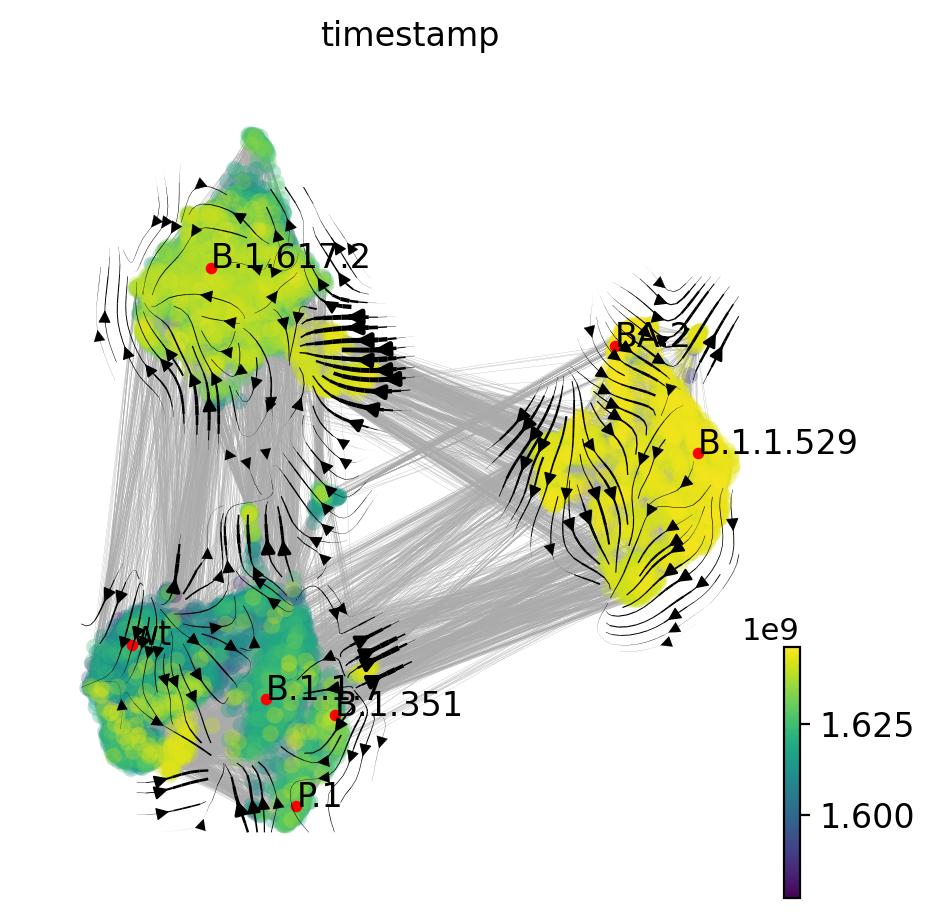

In [21]:
evo.set_figure_params(dpi_save=500, figsize=(5, 5.5))
plt.figure()
ax = evo.pl.velocity_embedding_stream(
    adata, basis='umap', min_mass=1., smooth=1., density=1.2,
    color='timestamp',show=False
    
)

sc.pl._utils.plot_edges(ax, adata, 'umap', 0.1, '#aaaaaa')
voc_name=VOC['Lineages'].values
for variant in voc_name:
    Y=adata[adata.obs["seq"]==VOC[VOC["Lineages"]==variant]["seq"].values[0]].obsm["X_umap"]
    sc.pl._utils.scatter_single(ax,Y,color="red")
    ax.annotate(variant, (Y[:,0], Y[:,1]))
#plt.savefig('figures/esm_gisaid_stream_label.png', dpi=500)

In [22]:
adata

AnnData object with n_obs × n_vars = 7594 × 1280
    obs: 'n_seq', 'seq', 'seqlen', 'gene_id', 'date', 'timestamp', 'host', 'group', 'country', 'continent', 'dataset', 'accession', 'louvain', 'velocity_self_transition'
    uns: 'louvain', 'neighbors', 'umap', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'velocity_umap'
    layers: 'velocity'
    obsp: 'connectivities', 'distances'

computing terminal states
    identified 10 regions of root nodes and 3 regions of end points .
    finished (0:00:01) --> added
    'root_nodes', root nodes of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


<Figure size 500x550 with 0 Axes>

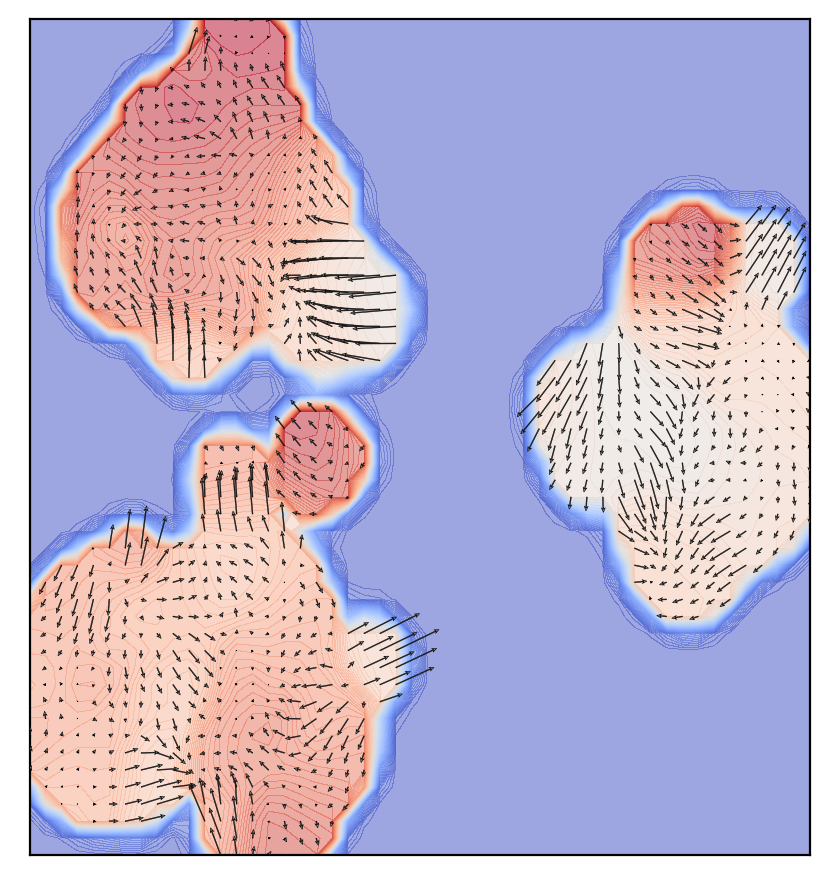

In [23]:
plt.figure()
ax=evo.pl.velocity_contour(
    adata,
    basis='umap', smooth=1., pf_smooth=1.5, levels=100,
    arrow_size=1., arrow_length=3., cmap='coolwarm',
    c='#aaaaaa',show=False
)
#plt.savefig('figures/esm_gisaid_contour.png', dpi=500,bbox_inches='tight')

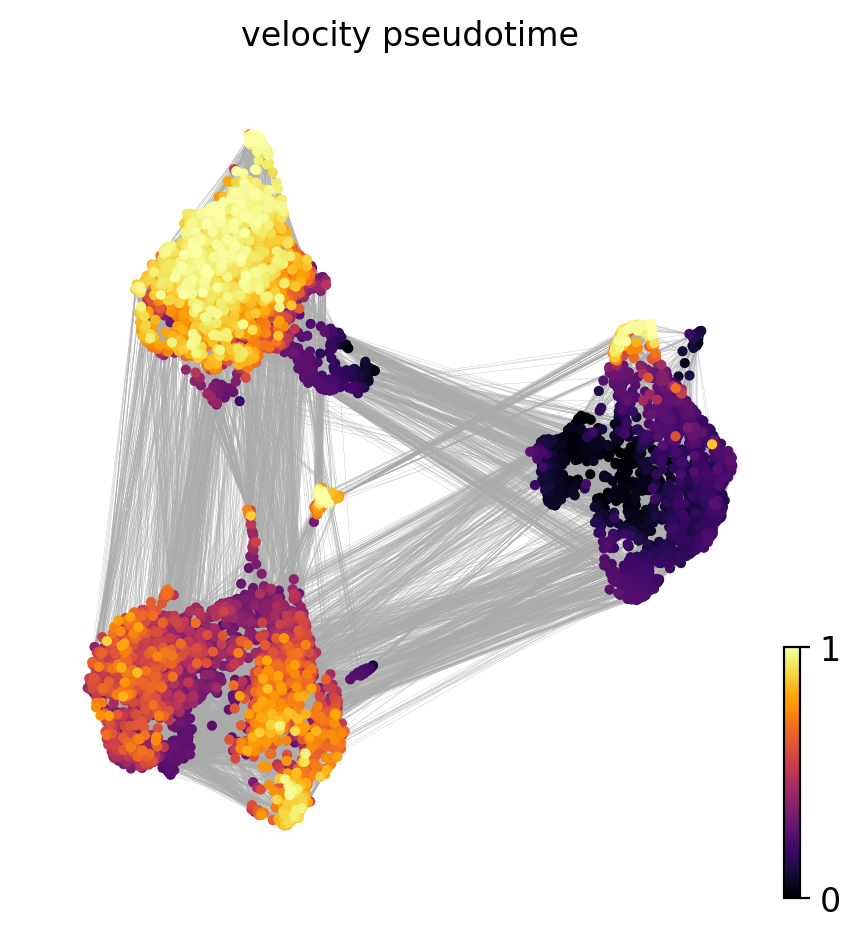

In [24]:
ax=scatter.scatter(adata,basis="umap",color="velocity_pseudotime",cmap='inferno',show=False,size=3*utils.default_size(adata),zorder=0)
sc.pl._utils.plot_edges(ax, adata, 'umap', 0.1, '#aaaaaa')
voc_name=VOC['Lineages'].values
#plt.savefig('figures/esm_gisaid_pseudotime.png', dpi=500)

In [25]:
## The spearman correlation
ss.spearmanr(adata.obs['velocity_pseudotime'],adata.obs['timestamp'],nan_policy='omit')

SpearmanrResult(correlation=-3.7465297437880835e-01, pvalue=1.1074850374493418e-251)

## Evolution velocity plot for synthetic variants

In [105]:
synthetic_score_df=pd.read_csv('../result/gisaid_synthetic_score.csv',index_col=0)

In [107]:
synthetic_embedding=np.load('../result/embedding_synthetic.npy')
synthetic_embedding=synthetic_embedding.reshape(synthetic_embedding.shape[0],-1)
synthetic_embedding.shape

(38869, 23220)

In [108]:
synthetic_embed_dict=dict(zip(synthetic_score_df["seq"],synthetic_embedding))

In [109]:
synthetic_score_df["exist"]=synthetic_score_df["seq"].apply(lambda x: x in seqs)

In [110]:
selected_synthetic=synthetic_score_df[synthetic_score_df["exist"]==False]

In [111]:
synthetic_seq={}
for _,record in selected_synthetic.iterrows():
    seq=Seq(record["seq"])
    if seq in seqs:
        raise ValueError("The seq has already exsited.")
    else:
        synthetic_seq[seq]=[]
    meta = {
            'gene_id': 'synthetic',
            'date': '2022-04-08',
            'timestamp': time.mktime(dparse('2022-04-08').timetuple()),
            'host': 'synthetic',
            'group': 'synthetic',
            'country': 'synthetic',
            'continent': 'synthetic',
            'dataset': 'synthetic',
            'accession': 'synthetic',
            'embedding': synthetic_embed_dict[record["seq"]],
            'score': record["mean_score"]
        }
    synthetic_seq[seq].append(meta)

In [112]:
synthetic_seq.update(seqs)

In [113]:
synthetic_adata = seqs_to_anndata(synthetic_seq)

In [128]:
synthetic_adata = synthetic_adata[
            synthetic_adata.obs['timestamp'] >=
            time.mktime(dparse('2019-12-24').timetuple())
        ]

In [129]:
synthetic_adata

View of AnnData object with n_obs × n_vars = 46455 × 23220
    obs: 'n_seq', 'seq', 'seqlen', 'gene_id', 'date', 'timestamp', 'host', 'group', 'country', 'continent', 'dataset', 'accession', 'score', 'louvain', 'velocity_self_transition'
    uns: 'neighbors', 'louvain', 'umap', 'model', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'velocity_umap'
    layers: 'velocity'
    obsp: 'distances', 'connectivities'

In [130]:
sc.pp.neighbors(synthetic_adata,n_neighbors=30,use_rep='X')
sc.tl.louvain(synthetic_adata,resolution=1)
sc.tl.umap(synthetic_adata,min_dist=1.)

In [118]:
synthetic_init=pd.read_csv('../data/2022-01-01_0.8.csv',index_col=0)

In [131]:
seq=synthetic_adata.obs["seq"]
init_index=seq[seq.isin(synthetic_init["seq"])].index

In [132]:
synthetic_adata.obs["dataset"][init_index]="init_seq"

In [133]:
velocity_graph(synthetic_adata, model_name="esm1b",score="confidence")

100%|██████████| 46455/46455 [00:07<00:00, 5866.68it/s]


In [134]:
evo.tl.velocity_embedding(synthetic_adata, basis='umap', scale=1.,
                            self_transitions=True,
                            use_negative_cosines=True,
                            retain_scale=False,
                            autoscale=True,)

computing velocity embedding
    finished (0:00:42) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 500x550 with 0 Axes>

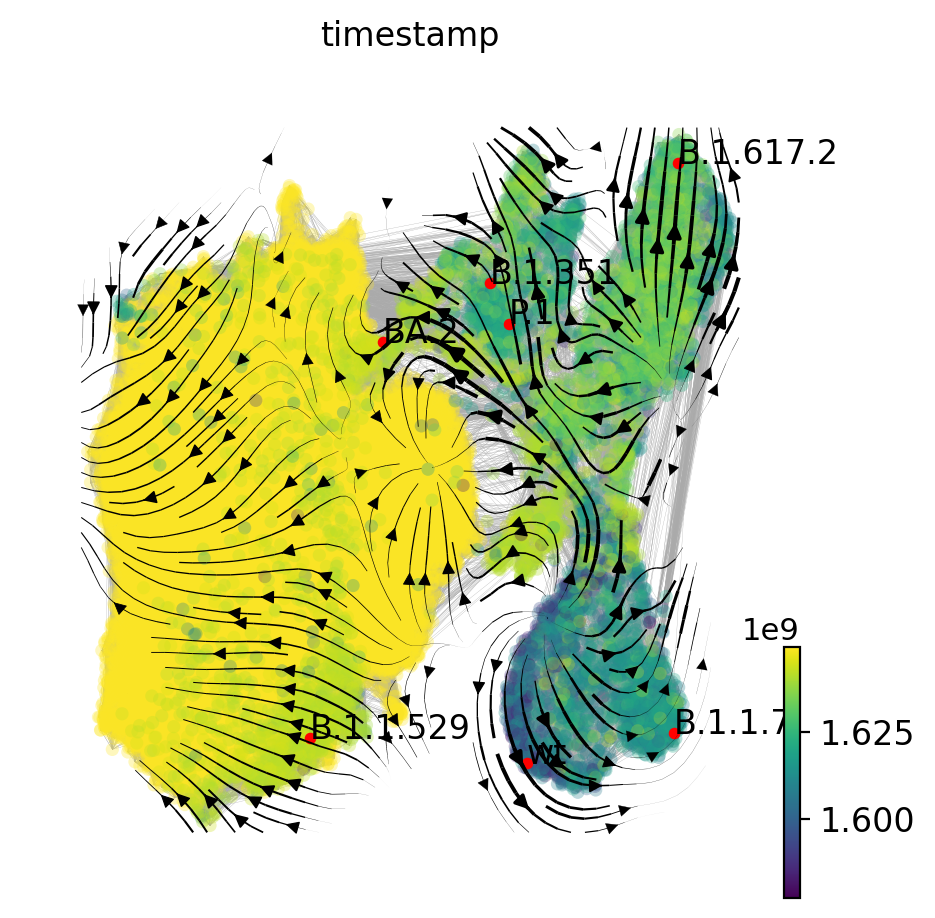

In [137]:
evo.set_figure_params(dpi_save=500, figsize=(5, 5.5))
plt.figure()
ax = evo.pl.velocity_embedding_stream(
    synthetic_adata, basis='umap', min_mass=1., smooth=1., density=0.8,
    color='timestamp',show=False,sort_order=False
    
)

sc.pl._utils.plot_edges(ax, synthetic_adata, 'umap', 0.1, '#aaaaaa')
voc_name=VOC['Lineages'].values
for variant in voc_name:
    Y=synthetic_adata[synthetic_adata.obs["seq"]==VOC[VOC["Lineages"]==variant]["seq"].values[0]].obsm["X_umap"]
    sc.pl._utils.scatter_single(ax,Y,color="red")
    ax.annotate(variant, (Y[:,0], Y[:,1]))
#plt.savefig('figures/gisaid_stream_label.png', dpi=500)


<Figure size 500x550 with 0 Axes>

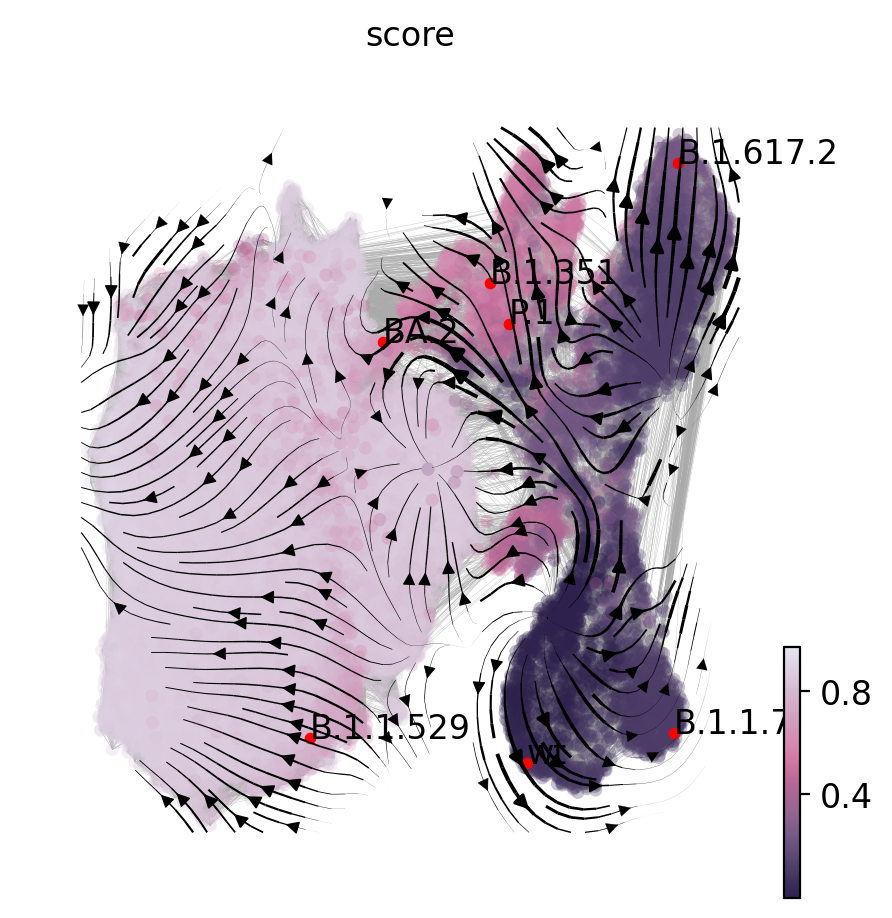

In [139]:
evo.set_figure_params(dpi_save=500, figsize=(5, 5.5))
plt.figure()
ax = evo.pl.velocity_embedding_stream(
    synthetic_adata, basis='umap', min_mass=1., smooth=1., density=0.8,
    color='score',show=False,sort_order=False,color_map=cm.acton
    
)

sc.pl._utils.plot_edges(ax, synthetic_adata, 'umap', 0.1, '#aaaaaa')
voc_name=VOC['Lineages'].values
for variant in voc_name:
    Y=synthetic_adata[synthetic_adata.obs["seq"]==VOC[VOC["Lineages"]==variant]["seq"].values[0]].obsm["X_umap"]
    sc.pl._utils.scatter_single(ax,Y,color="red")
    ax.annotate(variant, (Y[:,0], Y[:,1]))
#plt.savefig('figures/gisaid_stream_label.png', dpi=500)


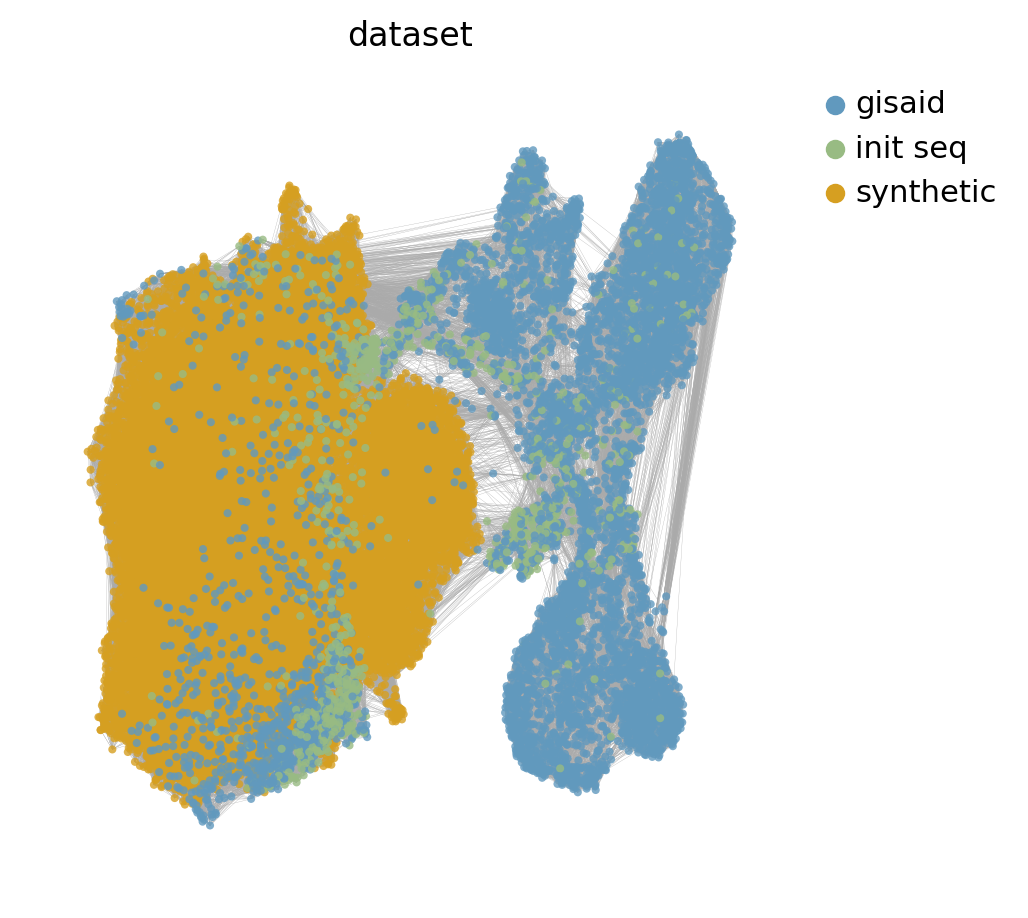

In [141]:
ax=scatter.scatter(synthetic_adata,basis="umap",color="dataset",show=False,size=3*utils.default_size(synthetic_adata),zorder=0,palette=["#6199be","#98bb83","#d69f21"],alpha=0.8)
sc.pl._utils.plot_edges(ax, synthetic_adata, 'umap', 0.1, '#aaaaaa')
#plt.savefig('/home/chenn0a/chenn0a/covid_esm1b/AttackProtein2/analysis/figures_4.3/attack2_dataset.png', dpi=500,bbox_inches="tight")